# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import csv
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from sklearn.utils import shuffle
import glob

%matplotlib inline


training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

Concatenate the training and validation sets so that after augmentation, the data can be split further into 20% of validation set.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# shape of an traffic sign image [width, height]
image_shape = [len(X_train[0]),len(X_train[0][0])]

# How many unique classes/labels there are in the dataset.
u, counts = np.unique(y_train, return_counts = True)
n_classes = len(counts)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

## Create a combined set of training and validation examples for augmentation
X_combined = np.concatenate((X_train, X_valid), axis = 0)
y_combined = np.concatenate((y_train, y_valid), axis = 0)
print("New Number of training examples =", X_combined.shape[0])

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43
New Number of training examples = 39209


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

Class IDs      Sign Names
	0 : Speed limit (20km/h)
	1 : Speed limit (30km/h)
	2 : Speed limit (50km/h)
	3 : Speed limit (60km/h)
	4 : Speed limit (70km/h)
	5 : Speed limit (80km/h)
	6 : End of speed limit (80km/h)
	7 : Speed limit (100km/h)
	8 : Speed limit (120km/h)
	9 : No passing
	10 : No passing for vehicles over 3.5 metric tons
	11 : Right-of-way at the next intersection
	12 : Priority road
	13 : Yield
	14 : Stop
	15 : No vehicles
	16 : Vehicles over 3.5 metric tons prohibited
	17 : No entry
	18 : General caution
	19 : Dangerous curve to the left
	20 : Dangerous curve to the right
	21 : Double curve
	22 : Bumpy road
	23 : Slippery road
	24 : Road narrows on the right
	25 : Road work
	26 : Traffic signals
	27 : Pedestrians
	28 : Children crossing
	29 : Bicycles crossing
	30 : Beware of ice/snow
	31 : Wild animals crossing
	32 : End of all speed and passing limits
	33 : Turn right ahead
	34 : Turn left ahead
	35 : Ahead only
	36 : Go straight or right
	37 : Go straight or left
	38 

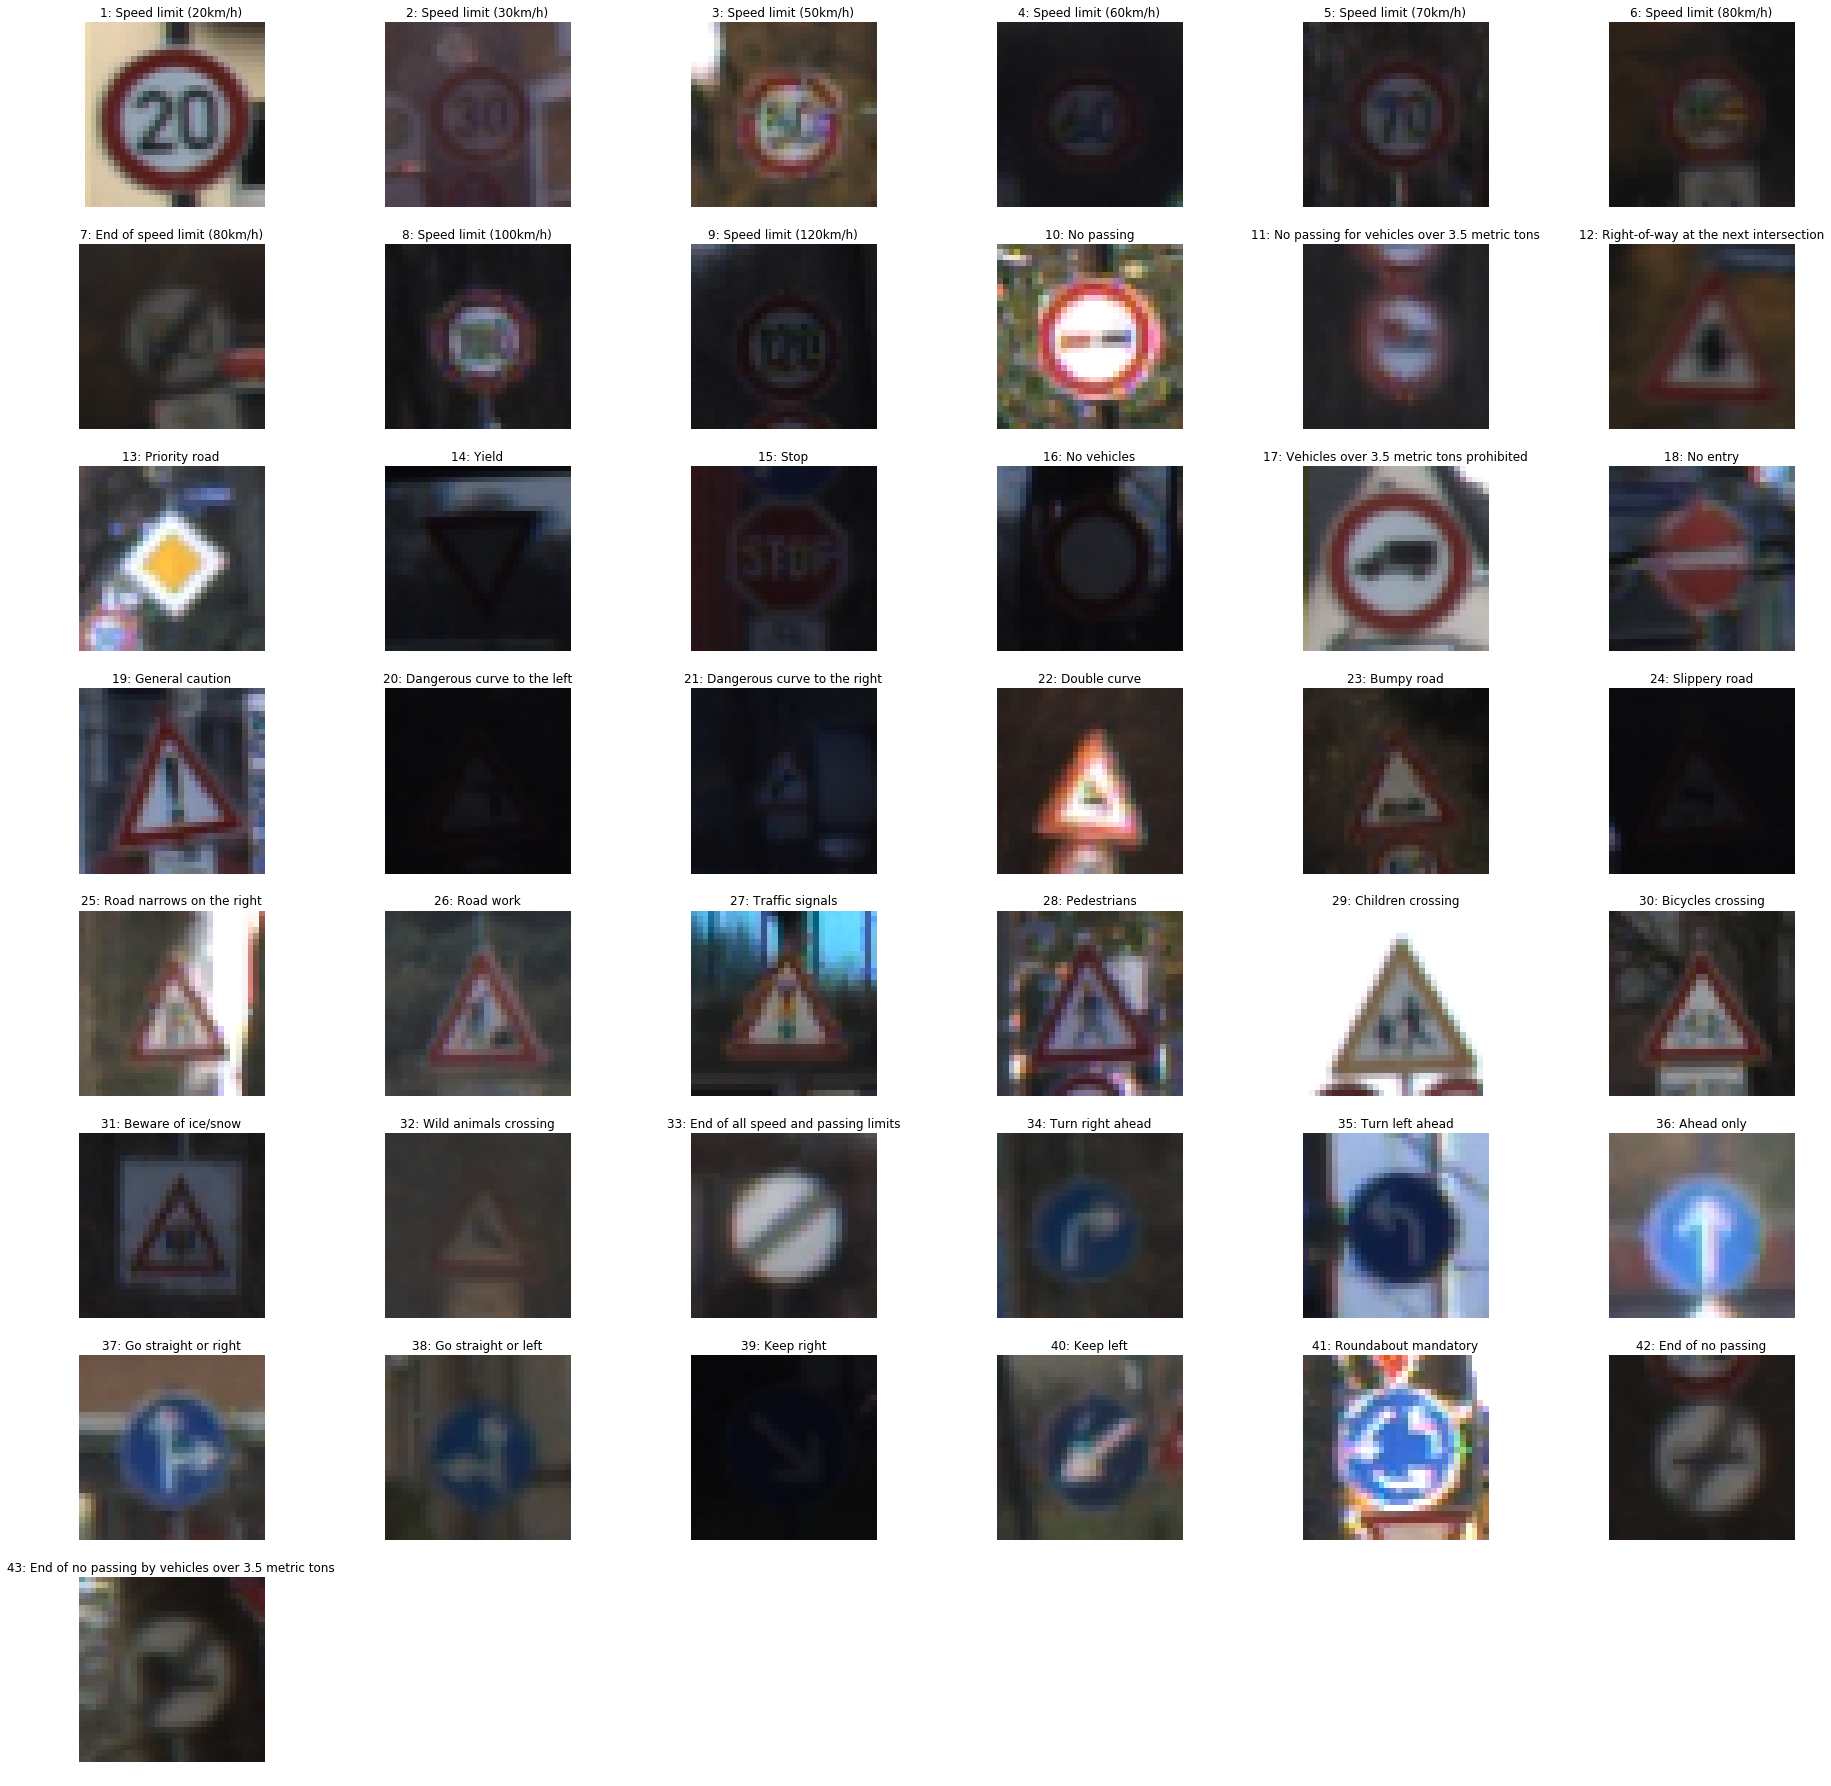

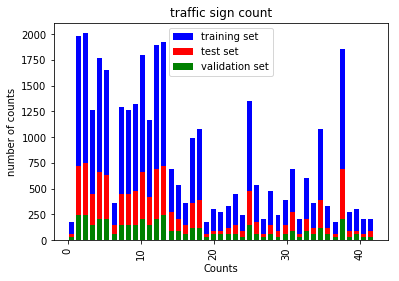

In [4]:
## Read CSV file
sign_names = []
with open('signnames.csv', mode='r') as csv_file:
    signnames = csv.DictReader(csv_file)
    print('Class IDs      Sign Names')
    for row in signnames:
        print(f'\t{row["ClassId"]} : {row["SignName"]}')
        sign_names.append(row["SignName"])

image_index = []
sample_img = []
for i in range(n_classes):
    image_index.append(np.where(y_train == i))
    sample_img.append(X_train[image_index[i][0][0]])

## Plot table of images
w=10
h=5
fig = plt.figure(figsize=(32, 32))
plt.tight_layout()
columns = 6
rows = 8
for i in range(1, n_classes+1):
    img = sample_img[i-1]
    figure = fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    figure.set_title(f'{i}: {sign_names[i-1]}')
plt.show()

hist, bins = np.histogram(y_train, bins=n_classes)
hist2, bins2 = np.histogram(y_valid, bins=n_classes)
hist3, bins3 = np.histogram(y_test, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xticks(rotation=90)
plt.bar(center, hist, align='center', width=width, color = 'b', label='training set')
plt.bar(center, hist3, align='center', width=width, color = 'r', label='test set')
plt.bar(center, hist2, align='center', width=width, color = 'g', label='validation set')
plt.title('traffic sign count')
plt.ylabel('number of counts')
plt.xlabel('Counts')
plt.legend(loc="best")
plt.show()

## Data augmentation
As seen from some of the past projects on traffic sign classifiers online, augmenting the data is a very good way to improve the performance of the neural network. 

The data was improved by translating, warping, rotating and changing the brightness of the data, to increase the amount of data for the neural network to train on. The amount of photos for training the network was then increased by 4 times. Some of the code here references Vivek Yadav's work.

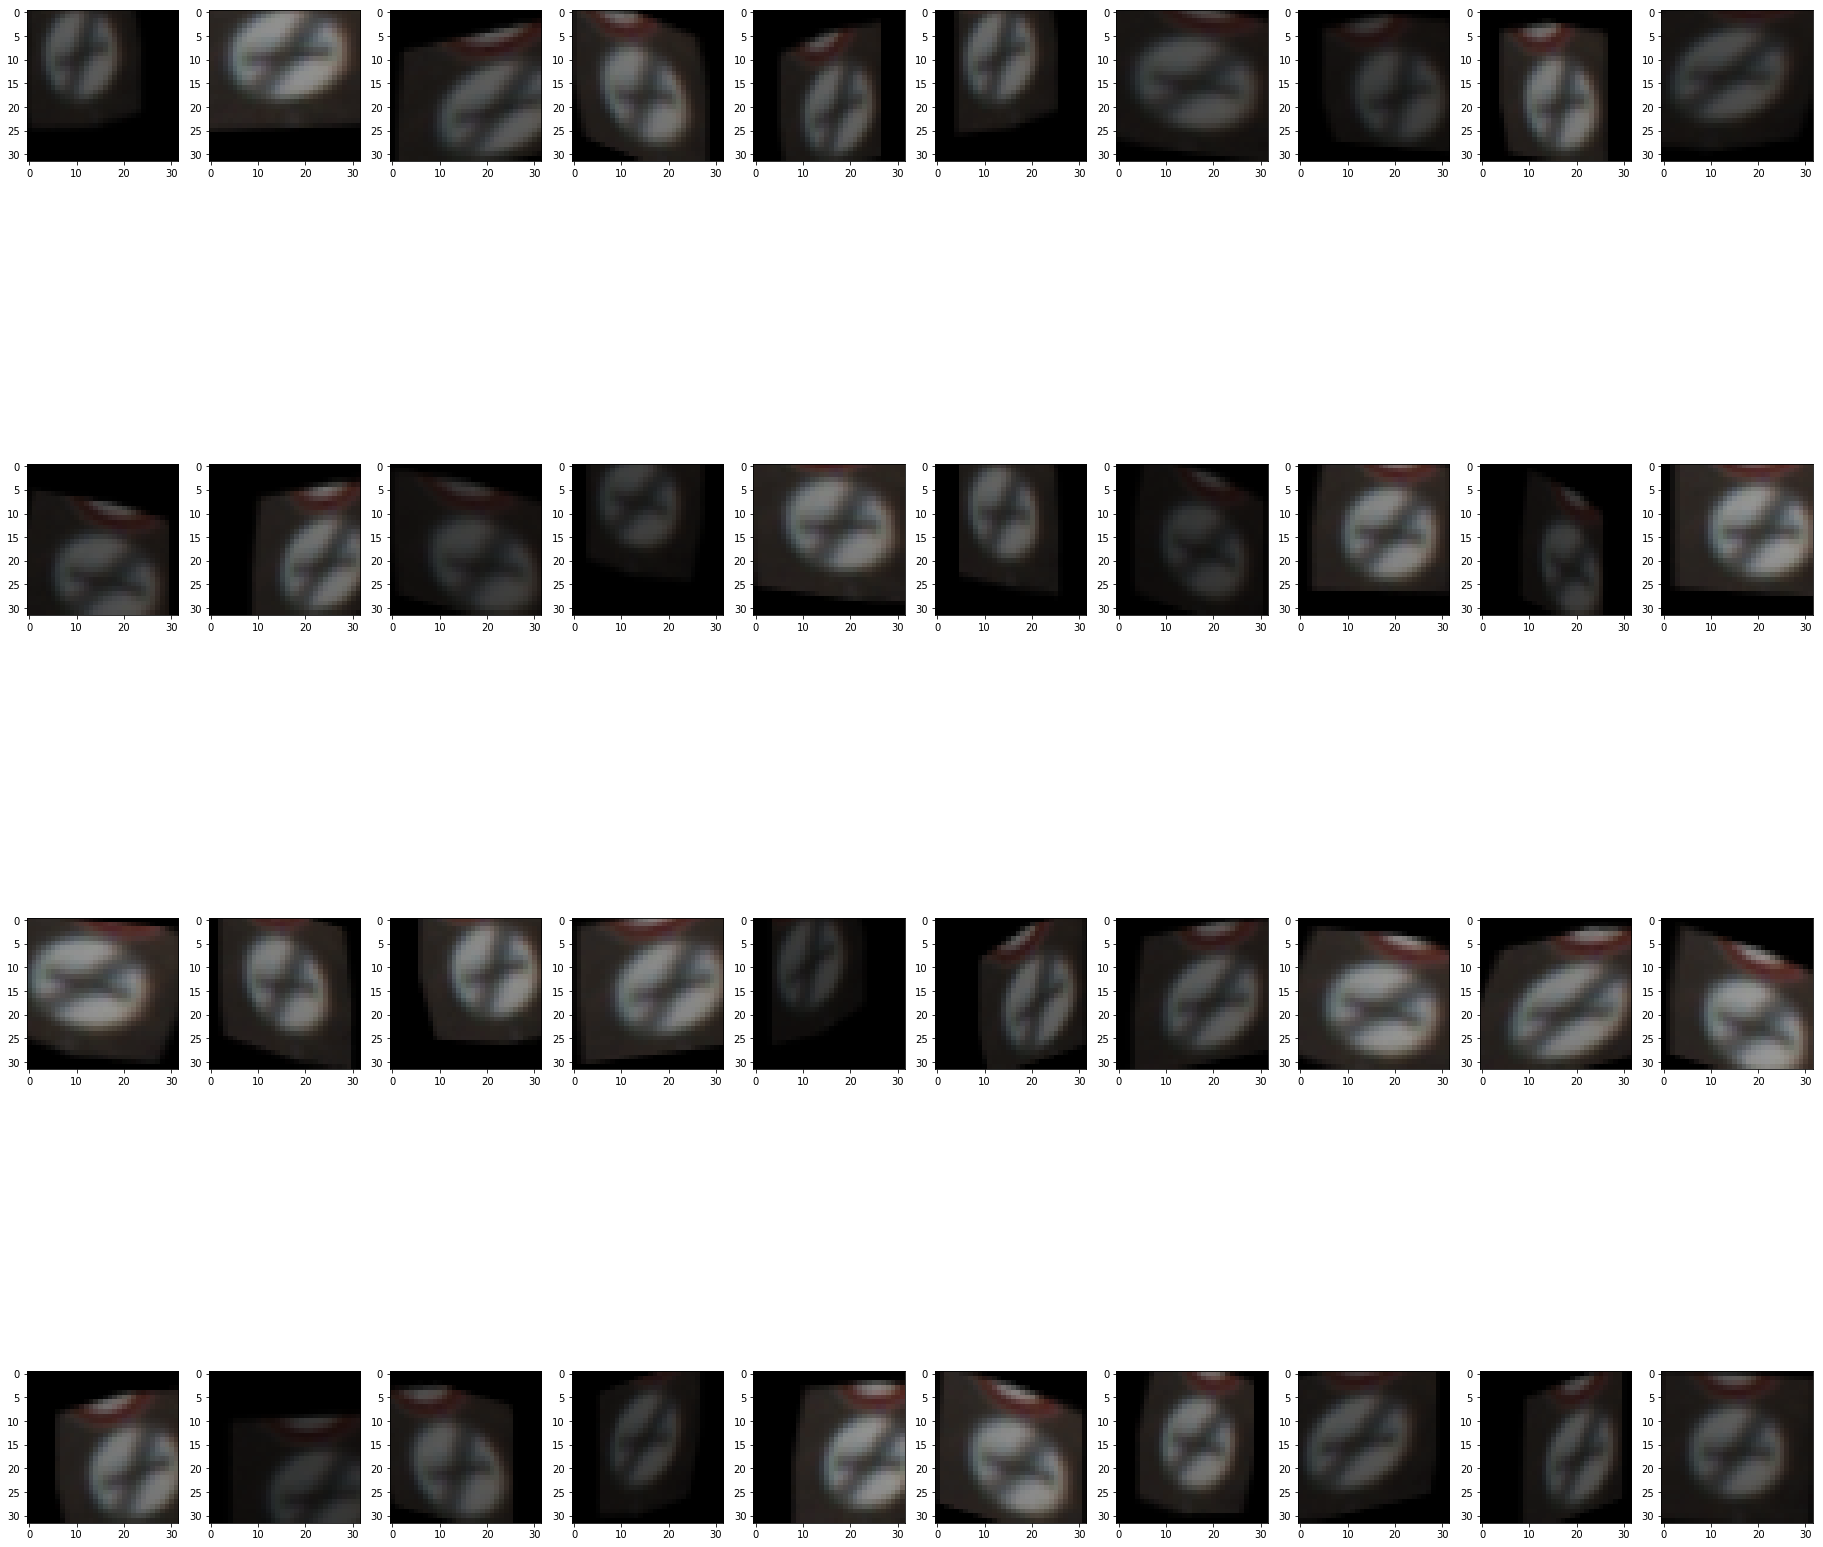

In [4]:
def augment_brightness(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    rand = np.random.uniform(0.5,1.5)
    image1 = np.array(image1, dtype = np.float64)
    ## Change the L value in the HLS
    image1[:, :, 1] = image1[:,:,1] * rand
    image1[:,:,1][image1[:,:,1]>255]= 255 # Prevent clipping
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HLS2RGB)
    return image1

def transform(image):
    rows,cols,depth = np.shape(image)
    
    #Rotate anywhere between +/- 20 deg
    angle = 20*np.random.uniform(-1, 1)
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    
    # Translate anywhere between +/- 5 pix
    dist = 5*np.random.uniform(-1,1)
    M_translate = np.float32([[1,0,dist],[0,1,dist]])
    
    #Perspective transform with +/-  7 pix
    pts1 = np.float32([[0,0],[32,0],[32,32],[0,32]])
    a = np.random.uniform(-1,1)
    b = np.random.uniform(-1,1)
    c = np.random.uniform(-1,1)
    d = np.random.uniform(-1,1)
    pts2 = np.float32([[7*a,7*b],
                       [32+7*c,7*d],
                       [32+7*c,32+7*d],
                       [7*a,32+7*b]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    
    #Distort!
    dst1 = cv2.warpAffine(image,M_rot,(cols,rows))
    dst2 = cv2.warpAffine(dst1,M_translate,(cols,rows))
    dst3 = cv2.warpPerspective(dst2,M,(cols,rows))
    return dst3

## Plot table of images
fig = plt.figure(figsize=(32, 32))
columns = 10
rows = 4

for i in range(1, 41):
    img = augment_brightness(transform(X_train[10]))
    figure = fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

##### Preprocess the data set

Apply the augment_brightness and transform function to multiply the dataset by 5 times, and make 20% of the dataset into validation set. The ratios of signs in each class was also kept the same.

The image data was then normalized so that the data has mean zero and equal variance. 

number of training sets is: 156836
number of validation sets is: 39209


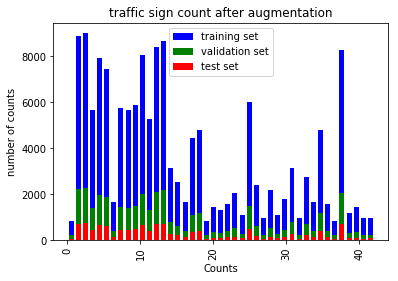

In [5]:
#Modify the dataset by increasing the data size by 4 times
X_combined_aug = [] 
y_combined_aug = [] 
num_aug = 4

for i in range(X_combined.shape[0]):
    img1 = X_combined[i]
    X_combined_aug.append(img1)
    y_combined_aug.append(y_combined[i])
    
    for x in range(num_aug):
        img = augment_brightness(transform(X_combined[i]))
        X_combined_aug.append(img)
        y_combined_aug.append(y_combined[i])
X_combined_aug = np.array(X_combined_aug)
y_combined_aug = np.array(y_combined_aug)


for i in range(n_classes):
    if i == 0:
        index_class = (y_combined_aug == i).nonzero()[0]
        train_length = int(index_class.shape[0]*0.8)
        X_train_index = index_class[:train_length]
        X_valid_index = index_class[train_length:]
        X_train_aug = X_combined_aug[X_train_index]
        y_train_aug = y_combined_aug[X_train_index]
        X_valid = X_combined_aug[X_valid_index]
        y_valid = y_combined_aug[X_valid_index]
    else:
        index_class = (y_combined_aug == i).nonzero()[0]
        train_length = int(index_class.shape[0]*0.8)
        X_train_index = index_class[:train_length]
        X_valid_index = index_class[train_length:]
        X_train_aug = np.append(X_train_aug, X_combined_aug[X_train_index], axis = 0)
        y_train_aug = np.append(y_train_aug, y_combined_aug[X_train_index], axis = 0)
        X_valid = np.append(X_valid, X_combined_aug[X_valid_index], axis = 0)
        y_valid = np.append(y_valid, y_combined_aug[X_valid_index], axis = 0)
# X_train_gray = np.sum(X_train_aug/3, axis=3, keepdims=True)
# X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)
# X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)

### Scale all values from -1 to 1, implement mean subtraction and normalisation
X_train_norm = (X_train_aug - 128)/128
X_train_norm -= np.mean(X_train_norm) 
X_train_norm /= np.std(X_train_norm) 

X_valid_norm = (X_valid - 128)/128
X_valid_norm -= np.mean(X_valid_norm) 
X_valid_norm /= np.std(X_valid_norm) 

X_test_norm = (X_test - 128)/128
X_test_norm -= np.mean(X_test_norm) 
X_test_norm /= np.std(X_test_norm) 

print("number of training sets is:", X_train_norm.shape[0])
print("number of validation sets is:", X_valid.shape[0])

# plt.subplot(1, 2, 1)
# plt.tight_layout()
# hist2, bins = np.histogram(y_train_aug, bins=n_classes)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist2, align='center', width=width)
# plt.title('Number of counts for train class')
# plt.ylabel('number of counts')

# plt.subplot(1, 2, 2)
# plt.tight_layout()
# hist3, bins = np.histogram(y_valid, bins=n_classes)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist3, align='center', width=width)
# plt.title('Number of counts for valid class')
# plt.ylabel('number of counts')
# plt.show

hist4, bins4 = np.histogram(y_train_aug, bins=n_classes)
hist5, bins5 = np.histogram(y_valid, bins=n_classes)
hist6, bins6 = np.histogram(y_test, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xticks(rotation=90)
plt.bar(center, hist4, align='center', width=width, color = 'b', label='training set')
plt.bar(center, hist5, align='center', width=width, color = 'g', label='validation set')
plt.bar(center, hist6, align='center', width=width, color = 'r', label='test set')
plt.title('traffic sign count after augmentation')
plt.ylabel('number of counts')
plt.xlabel('Counts')
plt.legend(loc="best")
plt.show()

### Model Architecture
## LeNet architecture 
Change log:

9 Nov: Implemented Grayscale and normalized over typical Lenet, with drop_out:0.8 and learning rate = 0.001. Best accuracy about 96% after 15 Epochs. 


11 Nov: Added one inception layer, sqrt(2/Fan_in) weight initialization. Increase FC1 layer sizes to 800 and 400. Best accuracy only about 89%. Revert to original Lenet structure for 93% accuracy.

12 Nov: Increased the dataset by 4 times using data augmentation. Increased number of EPOCHS to 50, training rate decay every 10 epochs. Accuracy does not go above 80%.

13 Nov: Tried out ViNet. Made images 32x32x3 again, and increased data size by 4 times, made validation set 20% of total set. Reduced dropout to 0.5. Very impressive behaviour as the accuracy reached 80% after 50 epochs and 15min.

14 Nov: 300000 samples takes too long, so use 150000 instead.
Increasing number of samples by 10 times to 300000 makes the operation too slow, so still using a data size of 150k. Tried 100 EPOCHS. Reached an accuracy of 85% and took 40min. Want to try 120 Epochs instead at lower decay rate of 0.9 every 20 iterations. Trained to 92% accuracy and 94.5% accuracy on Test data.

18 Nov: Made the validation set have the same class distribution as training set, as I suspected that this was causing the lack in accuracy for training. Loaded the ViNet architecture and ran 50 EPOCHS, best accuracy still about 92% with 0.0001 training rate. 95.2% accuracy on testdata! 

20 Nov: Made some slight modifications to augment brightness and the perspective transform, and retraining the model. The validation accuracy is about 94% now.

## Start off with the LeNet architecture
![LeNet](./lenet.png)

In [7]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional 5x5 Filter. Input = 32x32x1. Output = 32x32x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # Pooling. Input = 32x32x6. Output = 16x16x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional 5x5 filter. Output = 16x16x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Pooling. Input = 16x16x16. Output = 8x8x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')          

    # Flatten. Input = 8x8x16. Output = 1024.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1024. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Testing new architectures:
## After some research online, Vivek Yadav had a really accurate NN architecture

So this model is modelled after his architecture. I also experimented with adding in an inception layer, as seen by inception(), but did not use it in the end as it did not improve the accuracy much.

Image (32 x 32 x 3)| 
------------ | 
1x1 filter with depth 3  | 
relu | 
3x3 filter with depth 32 | 
relu | 
3x3 filter with depth 32 | 
relu + maxpool + dropout| 
3x3 filter with depth 64 | 
relu | 
3x3 filter with depth 64 | 
relu + maxpool + dropout| 
3x3 filter with depth 128 | 
relu | 
3x3 filter with depth 128 | 
relu + maxpool + dropout|
flatten|
fully connected 2048 neurons |
fully connected 1024 neurons |
fully connected 1024 neurons |
fully connected 43 neurons |
softmax|

In [8]:
## Inception layer, input of depth 64 and output of depth 64
def inception(x):
    mu = 0
    sigma = 0.1
    
    #1x1 convolution layer, depth/3
    x1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 64, 16), mean = mu, stddev = sigma*tf.sqrt(2/(48*16))))
    x1_b = tf.Variable(tf.zeros(16))
    x1   = tf.nn.conv2d(x, x1_W, strides=[1, 1, 1, 1], padding='SAME') + x1_b
    x1 = tf.nn.relu(x1)
    x1 = tf.nn.dropout(x1, keep_prob)
    
    #1x1 convolution layer, depth/2, followed by 3x3 convolution layer at depth 2/3
    x2_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 64, 24), mean = mu, stddev = sigma*tf.sqrt(2/(48*24))))
    x2_b = tf.Variable(tf.zeros(24))
    x2 = tf.nn.conv2d(x, x2_W, strides=[1, 1, 1, 1], padding='SAME') + x2_b
    x2 = tf.nn.relu(x2)
    x2 = tf.nn.dropout(x2, keep_prob)
    
    x2a_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 24, 32), mean = mu, stddev = sigma*tf.sqrt(2/(3*3*24*32))))
    x2a_b = tf.Variable(tf.zeros(32))
    x2 = tf.nn.conv2d(x2, x2a_W, strides=[1, 1, 1, 1], padding='SAME') + x2a_b
    x2 = tf.nn.relu(x2)
    x2 = tf.nn.dropout(x2, keep_prob)
    
    #1x1 convolution layer, depth/12, followed by 5x5 convolution layer at depth 1/6
    x3_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 64, 4), mean = mu, stddev = sigma*tf.sqrt(2/(48*4))))
    x3_b = tf.Variable(tf.zeros(4))
    x3 = tf.nn.conv2d(x, x3_W, strides=[1, 1, 1, 1], padding='SAME') + x3_b
    x3 = tf.nn.relu(x3)
    x3 = tf.nn.dropout(x3, keep_prob)
    
    x3a_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 4, 8), mean = mu, stddev = sigma*tf.sqrt(2/(5*5*4*8))))
    x3a_b = tf.Variable(tf.zeros(8))
    x3 = tf.nn.conv2d(x3, x3a_W, strides=[1, 1, 1, 1], padding='SAME') + x3a_b
    x3 = tf.nn.relu(x3)
    x3 = tf.nn.dropout(x3, keep_prob)
    
    #Max pooling layer, same padding and stride of 1, followed by 1x1 convolution layer at depth 1/6
    x4 = tf.nn.max_pool(x,[1, 3, 3, 1],[1, 1, 1, 1],padding='SAME')
    
    x4_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 64, 8), mean = mu, stddev = sigma*tf.sqrt(2/(48*8))))
    x4_b = tf.Variable(tf.zeros(8))
    x4 = tf.nn.conv2d(x4, x4_W, strides=[1, 1, 1, 1], padding='SAME') + x4_b
    x4 = tf.nn.relu(x4)
    x4 = tf.nn.dropout(x4, keep_prob)

    return tf.concat([x1, x2, x3, x4], 3)

def ViNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional 1x1 Filter. Input = 32x32x3. Output = 32x32x3.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, 3), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(3))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: 2 Convolutional 3x3 Filter with 32 depth followed by maxpool and dropout. Input = 32x32x3. Output = 16x16x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2a_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    conv2a_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv2, conv2a_W, strides=[1, 1, 1, 1], padding='SAME') + conv2a_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Layer 3: 2 Convolutional 3x3 Filter with 64 depth, followed by maxpool and dropout. Input = 16x16x32. Output = 8x8x64
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    conv3 = tf.nn.relu(conv3)
    conv3a_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma))
    conv3a_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv3, conv3a_W, strides=[1, 1, 1, 1], padding='SAME') + conv3a_b
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3 = tf.nn.dropout(conv3, keep_prob)
    
    # Inception layer
#     conv3 = inception(conv3)
    
    # Layer 4: 2 Convolutional 3x3 Filter with 128 depth, followed by maxpool and dropout. Input = 8x8x64. Output = 4x4x128
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(128))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    conv4 = tf.nn.relu(conv4)
    conv4a_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = mu, stddev = sigma))
    conv4a_b = tf.Variable(tf.zeros(128))
    conv4   = tf.nn.conv2d(conv4, conv4a_W, strides=[1, 1, 1, 1], padding='SAME') + conv4a_b
    conv4 = tf.nn.relu(conv4)
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4 = tf.nn.dropout(conv4, keep_prob)
    
    # SOLUTION: Flatten. Input = 4x4x128. Output = 2048.
    fc0   = flatten(conv4)
    
    # Layer 5: Fully Connected. Input = 2048. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 6: Fully Connected. Input = 1024, Output = 1024.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(1024))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 1024. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [55]:
# Remove the previous weights and bias
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

## Training Pipeline
EPOCHS = 100
BATCH_SIZE = 128
keep_prob = tf.placeholder(tf.float32)
rate = 0.001
beta = 0.01
accuracy = []
loss = []

logits = ViNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
loss_operation = tf.reduce_mean(loss_operation)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
print(x)
print(y)
print(one_hot_y)

Tensor("Placeholder:0", shape=(?, 32, 32, 3), dtype=float32)
Tensor("Placeholder_1:0", dtype=int32)
Tensor("one_hot:0", dtype=float32)


In [47]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_cost = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        
        current_cost = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_cost += (current_cost * len(batch_x))
    return total_accuracy / num_examples, total_cost / num_examples

For demo purposes I'm running the pre-trained code for 100 epochs

INFO:tensorflow:Restoring parameters from ./models/ViNet
Model restored.
Training...

EPOCH 1 ...
Validation Accuracy = 0.940
Current Cost = 0.200
learning rate 0.001

EPOCH 2 ...
Validation Accuracy = 0.934
Current Cost = 0.219
learning rate 0.001

EPOCH 3 ...
Validation Accuracy = 0.942
Current Cost = 0.189
learning rate 0.001

EPOCH 4 ...
Validation Accuracy = 0.941
Current Cost = 0.189
learning rate 0.001

EPOCH 5 ...
Validation Accuracy = 0.939
Current Cost = 0.200
learning rate 0.001

EPOCH 6 ...
Validation Accuracy = 0.945
Current Cost = 0.187
learning rate 0.001

EPOCH 7 ...
Validation Accuracy = 0.937
Current Cost = 0.207
learning rate 0.001

EPOCH 8 ...
Validation Accuracy = 0.938
Current Cost = 0.202
learning rate 0.001

EPOCH 9 ...
Validation Accuracy = 0.943
Current Cost = 0.188
learning rate 0.001

EPOCH 10 ...
Validation Accuracy = 0.942
Current Cost = 0.189
learning rate 0.0009000000000000001

EPOCH 11 ...
Validation Accuracy = 0.934
Current Cost = 0.224
learning rate 0

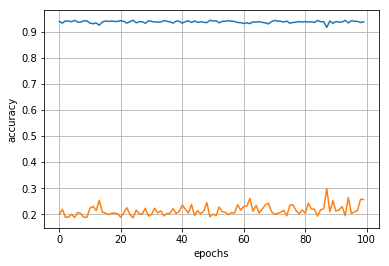

In [27]:
## Training the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./models/ViNet")
    print("Model restored.")
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_norm, y_train_aug = shuffle(X_train_norm, y_train_aug)
        
        ## Learning rate decay
        if (i+1)%10 == 0:
            rate *= 0.9
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_norm[offset:end], y_train_aug[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        validation_accuracy, current_cost = evaluate(X_train_norm, y_valid)
        accuracy.append(validation_accuracy)
        loss.append(current_cost)

        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Current Cost = {:.3f}".format(current_cost))
        print("learning rate", rate)
        print()
    
    saver.save(sess, './models/ViNet')
    print("Model saved")
    
    test_accuracy, cost = evaluate(X_test_norm, y_test)
    print('Test Accuracy: {:.3f}'.format(test_accuracy)) 
    
    sess.close()
    
epochs = np.arange(0, EPOCHS, 1)
fig, ax = plt.subplots()
ax.plot(epochs, accuracy)
ax.plot(epochs, loss)

ax.set(xlabel='epochs', ylabel='accuracy')
ax.grid()
plt.show()

## Testing the test accuracy of the model

Able to achieve about 96% accuracy on the test data

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './models/ViNet')
    print("Model restored")
    test_accuracy, cost = evaluate(X_test_norm, y_test)
    print('Test Accuracy: {:.3f}'.format(test_accuracy)) 

INFO:tensorflow:Restoring parameters from ./models/ViNet
Model restored
Test Accuracy: 0.959


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

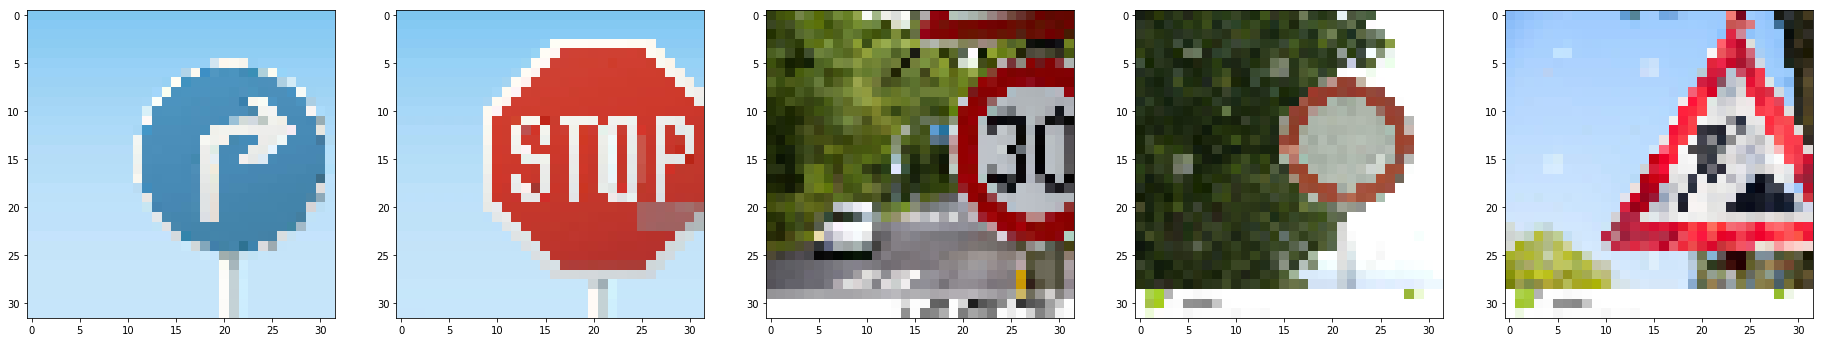

(5, 32, 32, 3)


In [53]:
images = [cv2.imread(file) for file in glob.glob("test_images/test*.jpg")]
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    y = images[i].shape[0]
    images[i] = images[i][:y,:y]
    images[i] = cv2.resize(images[i], (32, 32)) 
images = np.array(images)
fig = plt.figure(figsize=(32, 32))

columns = 5
rows = 2

for i in range(1, 6):
    img = images[i-1]
    figure = fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
print(images.shape)

# Normalize images
images_norm = (images - 128)/128
images_norm -= np.mean(images_norm) 
images_norm /= np.std(images_norm) 

my_labels = np.array([33,14, 1, 15, 25])

### Predict the Sign Type for  Images found on the web
normalize the 5 test images found on the web, and run the ViNet model on them, printing the accuracy of them.

Also run the logits forward and evaluate the top 5 predictions.

INFO:tensorflow:Restoring parameters from ./models/ViNet
Model restored.
My Accuracy: 0.4000000059604645


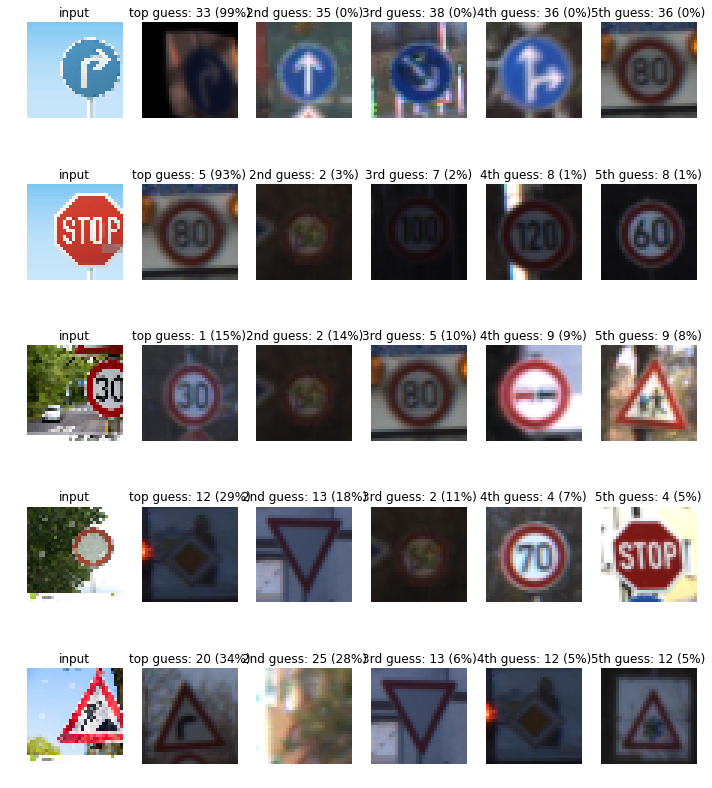

In [57]:
# Launch the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './models/ViNet')
    print("Model restored.")
    
    #results = sess.run(tf.argmax(logits, 1), feed_dict={x: images_norm, keep_prob:1.0})
    test_accuracy, cost = evaluate(images_norm, my_labels)
    print('My Accuracy: {}'.format(test_accuracy))
    
    ## Top 5 softmax for test images
    softmax_logits = tf.nn.softmax(logits)
    results = sess.run(softmax_logits, feed_dict={x: images_norm, keep_prob:1.0})
    results = sess.run(tf.nn.top_k(results, k = 5))
    
    ## Display the top 3 predictions
    fig, axs = plt.subplots(len(images),6, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(images):
        axs[6*i].axis('off')
        axs[6*i].imshow(images[i])
        axs[6*i].set_title('input')
        guess1 = results[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[6*i+1].axis('off')
        axs[6*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[6*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*results[0][i][0]))
        guess2 = results[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[6*i+2].axis('off')
        axs[6*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[6*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*results[0][i][1]))
        guess3 = results[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[6*i+3].axis('off')
        axs[6*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[6*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*results[0][i][2]))
        guess4 = results[1][i][3]
        index4 = np.argwhere(y_valid == guess4)[0]
        axs[6*i+4].axis('off')
        axs[6*i+4].imshow(X_valid[index4].squeeze(), cmap='gray')
        axs[6*i+4].set_title('4th guess: {} ({:.0f}%)'.format(guess4, 100*results[0][i][3]))
        guess5 = results[1][i][4]
        index5 = np.argwhere(y_valid == guess5)[0]
        axs[6*i+5].axis('off')
        axs[6*i+5].imshow(X_valid[index5].squeeze(), cmap='gray')
        axs[6*i+5].set_title('5th guess: {} ({:.0f}%)'.format(guess4, 100*results[0][i][4]))

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understanding the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


## Compare with the test images top 5 predictions

INFO:tensorflow:Restoring parameters from ./models/ViNet
Model restored.


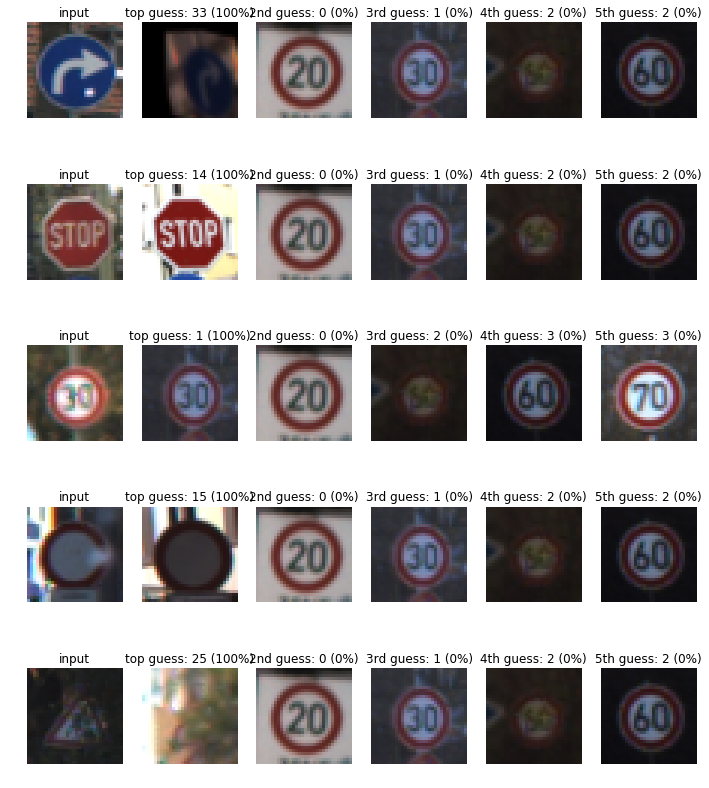

In [51]:
# Launch the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './models/ViNet')
    print("Model restored.")
    
    
    ## Top 5 softmax for test images
    softmax_logits = tf.nn.softmax(logits)
    
    images_norm = np.zeros_like(images)
    for i in range(len(my_labels)):
            index_label = (y_test == my_labels[i]).nonzero()[0]
            images_norm[i] = X_test[index_label[10]]
        
    results = sess.run(tf.nn.top_k(sess.run(softmax_logits, feed_dict={x: images_norm, keep_prob:1.0}), k = 5))
    
    ## Display the top 3 predictions
    fig, axs = plt.subplots(len(images),6, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(images):
        axs[6*i].axis('off')
        axs[6*i].imshow(images_norm[i])
        axs[6*i].set_title('input')
        guess1 = results[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[6*i+1].axis('off')
        axs[6*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[6*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*results[0][i][0]))
        guess2 = results[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[6*i+2].axis('off')
        axs[6*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[6*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*results[0][i][1]))
        guess3 = results[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[6*i+3].axis('off')
        axs[6*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[6*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*results[0][i][2]))
        guess4 = results[1][i][3]
        index4 = np.argwhere(y_valid == guess4)[0]
        axs[6*i+4].axis('off')
        axs[6*i+4].imshow(X_valid[index4].squeeze(), cmap='gray')
        axs[6*i+4].set_title('4th guess: {} ({:.0f}%)'.format(guess4, 100*results[0][i][3]))
        guess5 = results[1][i][4]
        index5 = np.argwhere(y_valid == guess5)[0]
        axs[6*i+5].axis('off')
        axs[6*i+5].imshow(X_valid[index5].squeeze(), cmap='gray')
        axs[6*i+5].set_title('5th guess: {} ({:.0f}%)'.format(guess4, 100*results[0][i][4]))